1. fill batch with trajectories, rewards and actions and logp_all of actions:

`a, v_t, logp_t, info_t = sess.run(get_action_ops, feed_dict={x_ph: o.reshape(1,-1)})`
1. perform an update :
    1.  assign placeholders `inputs = {k:v for k,v in zip(all_phs, buf.get())}`
        *   logp_all from batch become old_logp_all, logp-> logp_old_ph, state and action placeholders are filled from batch
    1. define delayed Hessian-vector function `Hx = lambda x : mpi_avg(sess.run(hvp, feed_dict={**inputs, v_ph: x}))`
    1. get gradient and loss f-ns `g, pi_l_old, v_l_old = sess.run([gradient, pi_loss, v_loss], feed_dict=inputs)`
        *   pi_loss forces to calculate `ratio = tf.exp(logp - logp_old_ph)` which means `pi, logp, logp_pi, info, info_phs, d_kl, v = actor_critic(x_ph, a_ph, **ac_kwargs)` is executed
        *   this means policy is recalculated for batch states/actions
    1.  launch`x = cg(Hx, g)`. 
        *   Means `v_ph, hvp = core.hessian_vector_product(d_kl, pi_params)` is ran. 
        *   Means d_kl was reused from `actor_critic(x_ph, a_ph, **ac_kwargs)`
        *   Means KL div was calculated using same policy
    1.  calculate NPG step size `alpha = np.sqrt(2*delta/(np.dot(x, Hx(x))+EPS))`
    1.  change policy params by step `old_params - alpha * x * step`
        *   recalculate `mpi_avg(sess.run([d_kl, pi_loss], feed_dict=inputs))`
        *   if NPG then break, else:
        *   Means `pi, logp, logp_pi, info, info_phs, d_kl, v = actor_critic(x_ph, a_ph, **ac_kwargs)` has to be recalculated using updated policy
        *   Means importance sampling 'kicks in'

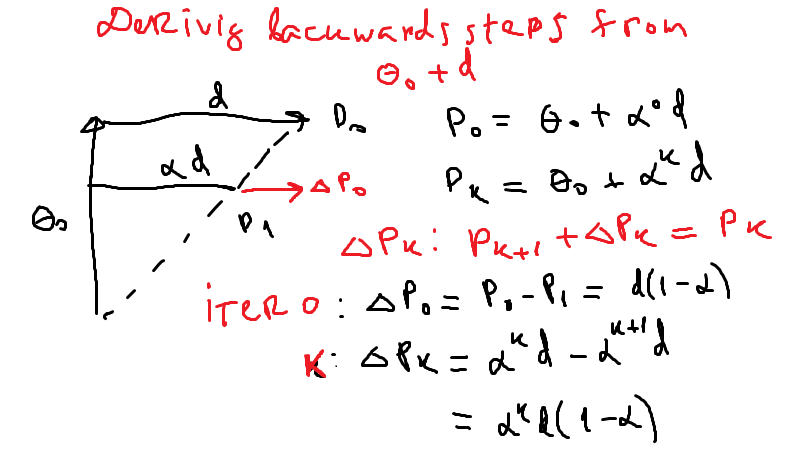

In [1]:
import matplotlib.pyplot as plt
import torch, gym, numpy as np
from tqdm import tqdm
from data_processing.neural_networks.DEEP_RL_Deep_Reinforcement_Learning.DEEP_RL_funcs import env_info, policy, value
# from torch.autograd.functional import jacobian
# from torch.autograd import grad
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from gym.spaces import Box, Discrete
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
from IPython.display import clear_output
clear_output()

def update_model_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        #p.data.copy_(flat_params[offset:offset+numel].view_as(p))
        p.data += flat_params[offset:offset+numel].view_as(p)
        offset += numel

In [2]:
class TRPO_env():
    """this 'wrapper' modifies env control
        automatically adds non terminal states, actions and reward into a buffer
        tracks episode rewards and calculates cumulative future rewards
        """
    def __init__(self, env_name, device = 'cpu', dtype = float, *args) -> None:
        self.env = gym.make(env_name, *args)
        self.batch_states       = []
        self.batch_actions      = []
        self.batch_rewards      = []
        self.episode_rewards    = []
        self.env_iters          = 0
        self.device             = device
        self.dtype              = float

    def clear_batches(self):
        self.batch_states  = []
        self.batch_actions = []
        self.batch_rewards = []

    def reset(self):
        state = self.env.reset()[0]
        state = torch.as_tensor(state, device=self.device, dtype = float)
        self.batch_states.append(state)
        self.episode_rewards    = []
        return state
    
    def step(self, action):
        self.batch_actions.append(torch.as_tensor(action)) # tensor in case its int or array. so i can torch.stack
        state, reward, done = self.env.step(action)[:3]
        state = torch.as_tensor(state, device=self.device, dtype = self.dtype)
        self.episode_rewards.append(reward)
        return state, reward, done
    
    def add_ep_rewards_2_go(self):
        #self.batch_rewards      += list(np.flip(np.cumsum(np.flip(self.episode_rewards))))
        ER = torch.tensor(self.episode_rewards, dtype= self.dtype)
        self.batch_rewards      += list(torch.flip(torch.cumsum(torch.flip(ER,dims=(0,)),dim=0),dims=(0,)))

    def add_ep_rewards_cum(self):
        self.batch_rewards      += [self.dtype(sum(self.episode_rewards))]*len(self.episode_rewards)

    @torch.no_grad()
    def play_batch(self, policy, max_batch_size, max_ep_len = 300, rew_type = None, tqdm_iter_params = None):
        # switch future reward approach. r2g = rewards to go. else cum-sum
        calc_rew = self.add_ep_rewards_2_go if rew_type in [None, 'r2g'] else self.add_ep_rewards_cum
        # reporting via tqdm
        if tqdm_iter_params is not None:
            tqdm_iter, tqdm_params = tqdm_iter_params
        # init
        self.clear_batches()
        policy.clear_batches()
        obs         = self.reset()
        t           = 0
        batch_times = []
        batch_L             = 0
        while True:
            if tqdm_iter_params is not None:
                tqdm_iter.set_postfix(**tqdm_params, batch_size = batch_L)

            action                      = policy.get_action(obs) 
            obs, _, episode_finished    = self.step(action)
            t                           += 1
            if episode_finished or t >= max_ep_len:
                self.env_iters += 1
                batch_times.append(t)

                calc_rew()
                t = 0
                batch_L = len(self.batch_states)
                if batch_L >= max_batch_size: 
                    policy.finalize_batch() # transform policy storage lists into tensors.
                    break               # end of batch. dont add terminal obs to batch_state
                obs = self.reset()    # start new episode. adds obs to batch_state
            else:
                self.batch_states.append(obs)

        self.batch_states     = torch.stack(self.batch_states ).to(**policy.tensor_params)
        self.batch_actions    = torch.stack(self.batch_actions).to(**policy.tensor_params)
        self.batch_rewards    = torch.tensor(self.batch_rewards, **policy.tensor_params)

        return torch.as_tensor(batch_times).to(float)

class MLP():
    def __init__(self, inp_size, out_size, hidden_sizes, activation = nn.Tanh,activation_out = nn.Identity, lr = 1e-2) -> None:
        self.dtype          = float
        self.act            = activation
        self.act_out        = activation_out
        self.layer_sizes    = [inp_size] + hidden_sizes + [out_size]
        self.mlp            = self.seq()
        self.optimizer      = Adam(self.mlp.parameters(), lr=lr)
        self.device         = "cpu"
        self.tensor_params     = {'dtype':self.dtype, 'device':self.device}

    def seq(self):
        layers      = []
        for i,j in zip(self.layer_sizes[:-1],self.layer_sizes[1:]):
            layers  += [nn.Linear(i,j, dtype=self.dtype), self.act()]
        layers[-1]  = self.act_out()
        return nn.Sequential(*layers)
    
    def to(self, device):
        self.mlp.to(device)
        self.device = device  
        self.tensor_params     = {'dtype':self.dtype, 'device':self.device}
    
class Policy_Discrete(MLP):
    def __init__(self, obs_dim, num_actions, hidden_sizes, activation=nn.Tanh, activation_out=nn.Identity, lr=0.01, batch_len = 5000) -> None:
        super().__init__(obs_dim, num_actions, hidden_sizes, activation, activation_out, lr)
        self.batch_len      = batch_len
        # for importance sampling
        self.logP_policy    = []  #batch length x 1
        self.logP_policy_old= []  #batch length x 1
        # for KL divergence
        self.logP_all       = []  #batch length x num actions
        self.logP_all_old   = []  #batch length x num actions
        # other
        self.D_KL           = torch.tensor(0.0, **self.tensor_params)
        self.U_rew          = torch.tensor(0.0, **self.tensor_params)
        self.U_rew_old      = torch.tensor(0.0, **self.tensor_params)
        self.MLP_num_prms   = sum(p.numel() for p in self.mlp.parameters())
        self.grad           = torch.zeros(size = (self.MLP_num_prms ,), **self.tensor_params)

    def get_policy(self, observation): # probs over actions for an obs
        return Categorical(logits=self.mlp(observation))
    
    def get_action(self, observation):
        """ Policy class: During experiment remember distribution log(P(.,s)) and log(P(a,s))
            Env class   : remember stats and actions, rewards."""
        distribution    = self.get_policy(observation)
        action          = distribution.sample()              # action taken
        self.logP_policy_old.append(distribution.log_prob(action))  # log(P(a,s))
        self.logP_all_old   .append(torch.log(distribution.probs))  # log(P(.,s))
        return action.item()
   
    def finalize_batch(self):
        self.logP_policy_old    = torch.tensor(self.logP_policy_old, **self.tensor_params)
        self.logP_all_old       = torch.stack(self.logP_all_old).to(**self.tensor_params)

    def clear_batches(self):
        self.logP_policy    = []  
        self.logP_policy_old= []  
        self.logP_all       = []  
        self.logP_all_old   = []  

    def batch_calc_logPs(self, observations, actions):
        """ Generate new log probs using current version of policy
            (on first iteration it will be the same policy = NPG)"""
        cat_dist        = self.get_policy(observations) 
        self.logP_all   = torch.log(cat_dist.probs)#.to(**self.tensor_params)     
        self.logP_policy= cat_dist.log_prob(actions)    
        
    def calc_KL_div(self):
        temp        = torch.exp(self.logP_all_old)*(self.logP_all_old- self.logP_all)
        return temp.sum(dim=-1).mean()

    def calc_surrogate_reward(self, advantages):
        ratios_vec = torch.exp(self.logP_policy - self.logP_policy_old)
        return (ratios_vec * advantages).mean()

    def calc_grad(self, f, create_graph = True, retain_graph = True):
        g = torch.autograd.grad(f, self.mlp.parameters(), create_graph=create_graph, retain_graph=retain_graph)
        return torch.cat([p.view(-1) for p in g]) 
    
    
def conjugate_gradient_hess(Av, b, x0=None, max_iters = None, tol = 1e-10):
  
    x = torch.zeros_like(b) if x0 is None else x0  #init guess

    r           = b - Av(x)    # residual
    d           = r.clone()  # direction
    rr          = torch.dot(r,r)
    num_iters   = len(b) if max_iters is None else max_iters
    for _ in range(num_iters):
        Ad          = Av(d)
        step_size   = rr/ (d @ Ad)
        x           += step_size * d
        r           -= step_size * Ad
        rr_new      = torch.dot(r,r)
        if rr_new < tol: break
        d           = r + (rr_new/rr)*d
        rr          = rr_new.clone()
    return x.detach()

In [20]:
env_CP      = TRPO_env('CartPole-v1',device=device)
num_obs     = env_CP.env.observation_space.shape[0]
num_acts    = env_CP.env.action_space.n
progress    = []
progress_std= []

env_CP_policy   = Policy_Discrete(   num_obs, num_acts   , [32])
env_CP_policy.optimizer = None
env_CP_value    = value(    num_obs, 1          , [32], lr = 0.1)
env_CP_policy.to(device)
env_CP_value.to(device)

In [21]:
batch_size = 1000
tq_iter     = tqdm(range(30))

std_steps, avg_steps = 0,0
tq_prms     = {'std_steps':std_steps,'avg_steps':avg_steps,'evals':env_CP.env_iters}
reward_cap  = 300
advantage   = 'r2g'
delta       = 1e-2
backtrack_coeff = 0.8
step_len = lambda k: backtrack_coeff**k*(1-backtrack_coeff) # see derivation image
backtrack_iters = 10
damping = 0.1
EPS = 1e-8
for _ in tq_iter:
    # GATHER TRAJECTORIES
    batch_times = env_CP.play_batch(env_CP_policy, batch_size, reward_cap, advantage, (tq_iter,tq_prms))

    # fit state value function
    env_CP_value.train(env_CP.batch_states, env_CP.batch_rewards, n_iters=10)
    alpha       = 1
    b_s         = env_CP_value.get_value(env_CP.batch_states)
    advantages  = env_CP.batch_rewards.reshape(-1,1) - b_s
    # prep log new probs. with grad.
    env_CP_policy.batch_calc_logPs(env_CP.batch_states, env_CP.batch_actions)
    env_CP_policy.U_rew     = env_CP_policy.calc_surrogate_reward(advantages)
    
    U_rew_g =torch.autograd.grad(env_CP_policy.U_rew, env_CP_policy.mlp.parameters(), create_graph=True, retain_graph=True)
    U_rew_g = torch.cat([grad.view(-1) for grad in grads])
    env_CP_policy.grad      = U_rew_g#env_CP_policy.calc_grad(env_CP_policy.U_rew, retain_graph=False).detach()
    env_CP_policy.D_KL      = env_CP_policy.calc_KL_div()

    # calculate ascent direction $\vec{x} = H^{-1} \vec{g}$
    #grad_KL = env_CP_policy.calc_grad(env_CP_policy.D_KL, create_graph=True, retain_graph=True)

    # def Hv(x):
    #     return env_CP_policy.calc_grad(grad_KL @ x, create_graph=False, retain_graph = None)
    
    # def Fvp(v):
    #     grads = torch.autograd.grad(env_CP_policy.D_KL, env_CP_policy.mlp.parameters(), create_graph=True, retain_graph=True)
    #     flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])
    #     kl_v = (flat_grad_kl * v).sum()
    #     grads = torch.autograd.grad(kl_v, env_CP_policy.mlp.parameters(), retain_graph=True)
    #     flat_grad_grad_kl = torch.cat([grad.view(-1) for grad in grads])

    #     return flat_grad_grad_kl + v * damping
    
    H = []
    grads = torch.autograd.grad(env_CP_policy.D_KL, env_CP_policy.mlp.parameters(), create_graph=True, retain_graph=True)
    flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])
    for i in range(len(flat_grad_kl)):
        grs = torch.autograd.grad(flat_grad_kl[i], env_CP_policy.mlp.parameters(), retain_graph=True)
        H.append(torch.cat([gg.view(-1) for gg in grs]))

    H = torch.stack(H)
    H += 0.001 * torch.eye(len(flat_grad_kl), **env_CP_policy.tensor_params)

    H_inv = torch.linalg.inv(H)

    #x = conjugate_gradient_hess(Hv, env_CP_policy.grad, max_iters=10)
    #x = conjugate_gradient_hess(Fvp, env_CP_policy.grad, max_iters=10)
    x = H_inv @ env_CP_policy.grad
    #alpha = torch.sqrt(2*delta/(torch.dot(x, Hv(x))+EPS))
    alpha = torch.sqrt(2*delta/(torch.dot(env_CP_policy.grad,x)+EPS))
    # set params to NPG step
    update_model_params(env_CP_policy.mlp, alpha * x)   
    accept_update = True
    fraction_travelled = 0
    if env_CP_policy.D_KL > delta:  # else NPG step will remain
        with torch.no_grad():
            env_CP_policy.U_rew_old = env_CP_policy.U_rew.clone()
            # begin backtracking (backwards from \theta_0 + \alpha x in -x direction)
            for j in range(backtrack_iters):
                step_size = step_len(j)
                fraction_travelled += step_size
                update_model_params(env_CP_policy.mlp, -step_size *alpha * x )
                env_CP_policy.batch_calc_logPs(env_CP.batch_states, env_CP.batch_actions)
                env_CP_policy.U_rew = env_CP_policy.calc_surrogate_reward(advantages)
                env_CP_policy.D_KL  = env_CP_policy.calc_KL_div()
                if env_CP_policy.D_KL <= delta and env_CP_policy.U_rew <= env_CP_policy.U_rew_old:
                    break   # accept update
                if j==backtrack_iters-1:
                    accept_update = False
                    print(f'Could not converge in {backtrack_iters} iterations! Restarting experiment.')
                    update_model_params(env_CP_policy.mlp, -(1-fraction_travelled)*alpha * x ) # finish path to \theta_0
                    break
                j += 1

        
    if accept_update:
        std_steps, avg_steps = torch.std_mean(torch.as_tensor(batch_times).to(float))
        std_steps,avg_steps = std_steps.item(), avg_steps.item()
        step = (1-fraction_travelled)
        tq_prms = {'std_steps':std_steps,'avg_steps':avg_steps,'evals':env_CP.env_iters, 'alpha':step}
        tq_iter.set_postfix(**tq_prms)
        #print(f'{avg_steps = :0.2f}, {std_steps = :0.2f}')
        progress.append(avg_steps)
        progress_std.append(std_steps)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s, avg_steps=0, batch_size=0, evals=0, std_steps=0]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 30/30 [04:10<00:00,  8.35s/it, alpha=1, avg_steps=19.5, evals=1344, std_steps=8.87]                


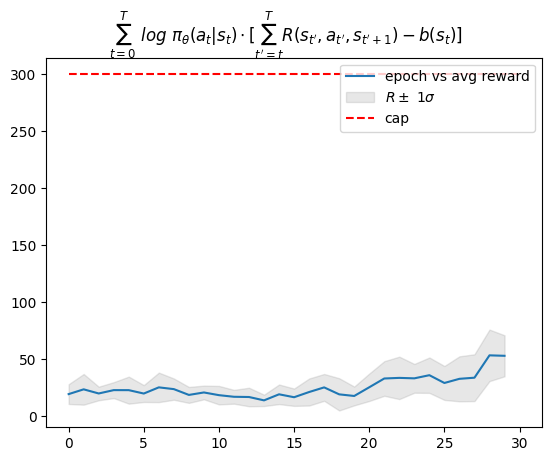

In [14]:
x = torch.arange(len(progress))
y1 = torch.tensor(progress)
y2 = torch.tensor(progress_std)
plt.plot(x,y1, label='epoch vs avg reward')    ;
plt.fill_between(x, y1 - y2, y1 + y2, color='#888888', alpha=0.2, label='$R\pm$ 1$\sigma$')
plt.hlines(reward_cap, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()
plt.suptitle(r'$\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot [\sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)]$');